In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [4]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df = df[df.price <= 1000]
    X = df[[x for x in df.columns if x not in ['price','bhk']]]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join(X)+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [5]:
rome = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfm.csv',
                   encoding='utf8')

In [6]:
df_corr = rome[[x for x in rome.columns if x not in ['Unnamed: 0','bhk']]].corr()

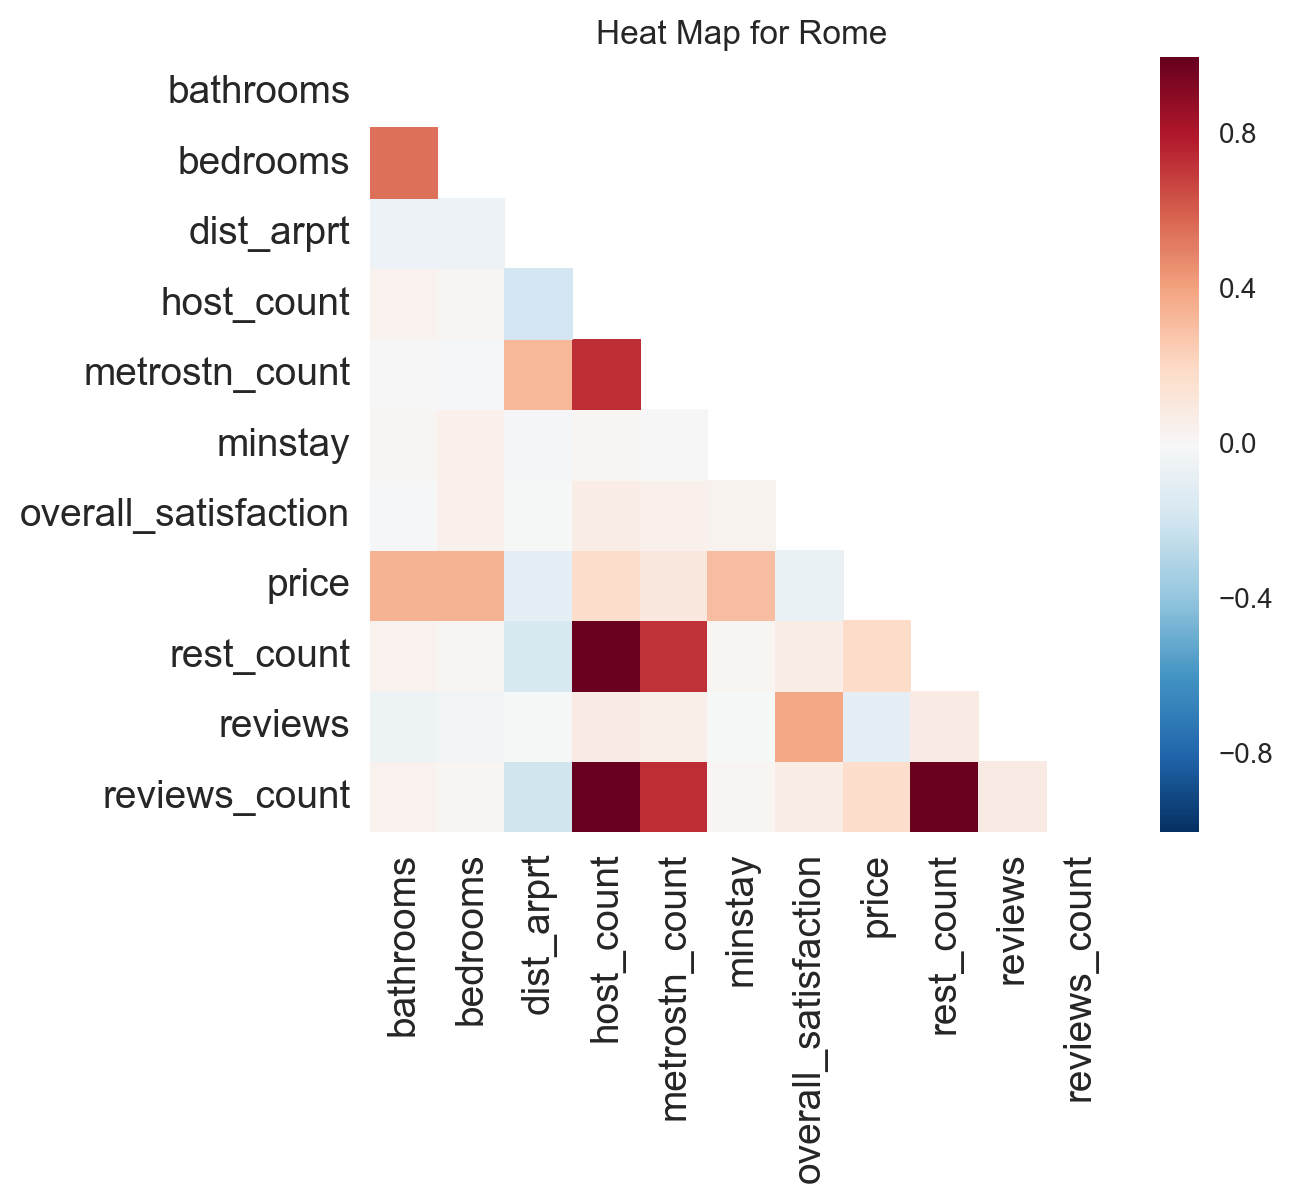

In [7]:
#for heatmap Set the default matplotlib figure size to 7x7:

plt.rcParams['figure.figsize']=(6,5)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
ax.set_title('Heat Map for Rome')

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [8]:
X, y = pred_target(rome)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [10]:
X_train.shape, X_test.shape

((10909, 26), (4676, 26))

In [11]:
linmod = LinearRegression()

In [12]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.52566546  0.53181052  0.52651998  0.52305743  0.51456555  0.49819659
  0.50467489  0.50825005  0.48489315  0.51136962]
0.51290032369
0.0137992997957


In [13]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.508781934635


In [14]:
residuals = y_test - predictions
residuals

array([ 0.0332301 ,  0.05199032,  0.13409189, ..., -0.16395491,
        0.18317083,  0.0105603 ])

In [15]:
np.mean(predictions)


4.5664065199435004

In [16]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
linmod.score(X_test, y_test)

0.51414749793369741

In [18]:
#linmod.coef_

In [19]:
print np.mean(y_train), np.mean(y_test)

4.55642154494 4.5663005422


In [20]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [21]:
Xn = StandardScaler().fit_transform(X)

In [22]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [23]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [24]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [25]:
import time


In [26]:
start_time = time.time()

alpha = 0.00214535045545
l1_ratio = 0.919183673469

enet = ElasticNet(alpha= alpha, l1_ratio=l1_ratio)

y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

print("--- %s seconds ---" % (time.time() - start_time))


ElasticNet(alpha=0.00214535045545, copy_X=True, fit_intercept=True,
      l1_ratio=0.919183673469, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.502042
--- 0.167071819305 seconds ---


In [27]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [28]:
lassocv.fit(Xn_train, y_train)

/Users/Jyots/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [29]:
lassocv.alpha_

0.00027954862037791664

In [30]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00027954862037791664, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.502192


In [31]:
residuals = np.exp(y_test) - np.exp(y_pred_enet)

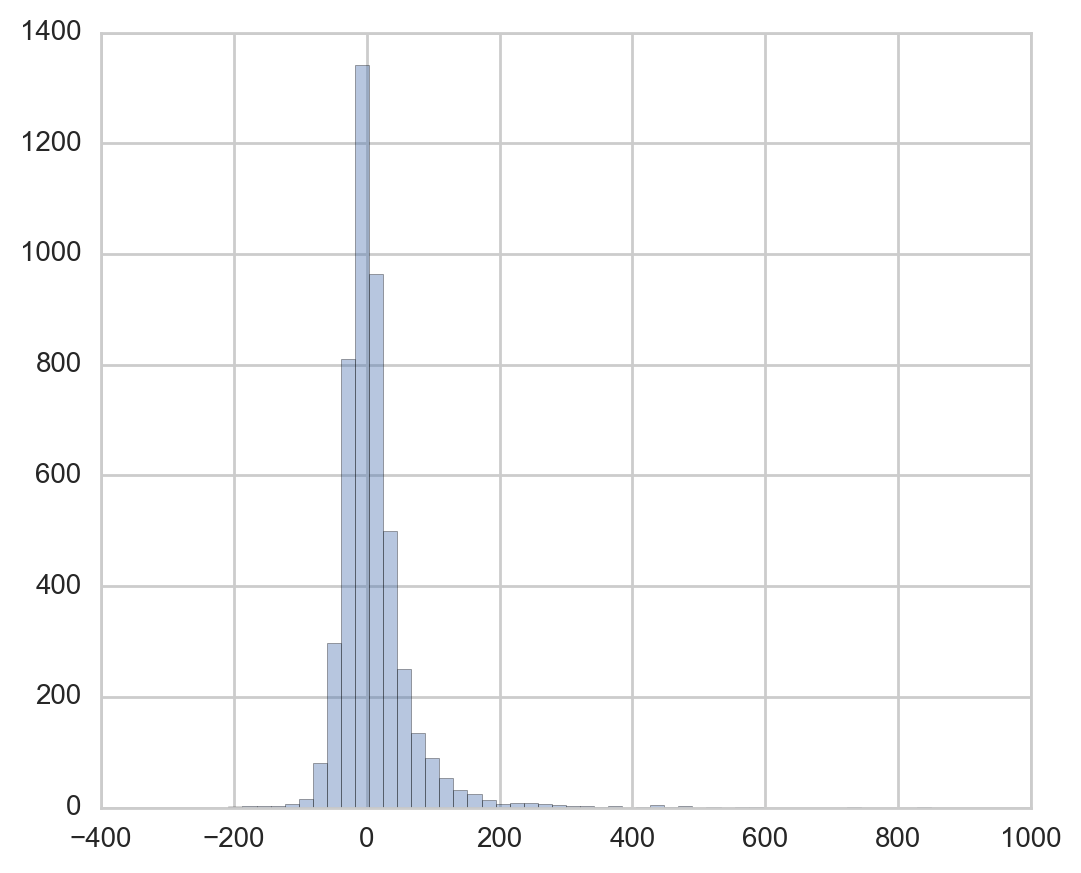

In [32]:
sns.distplot(residuals, bins=50, kde=False)

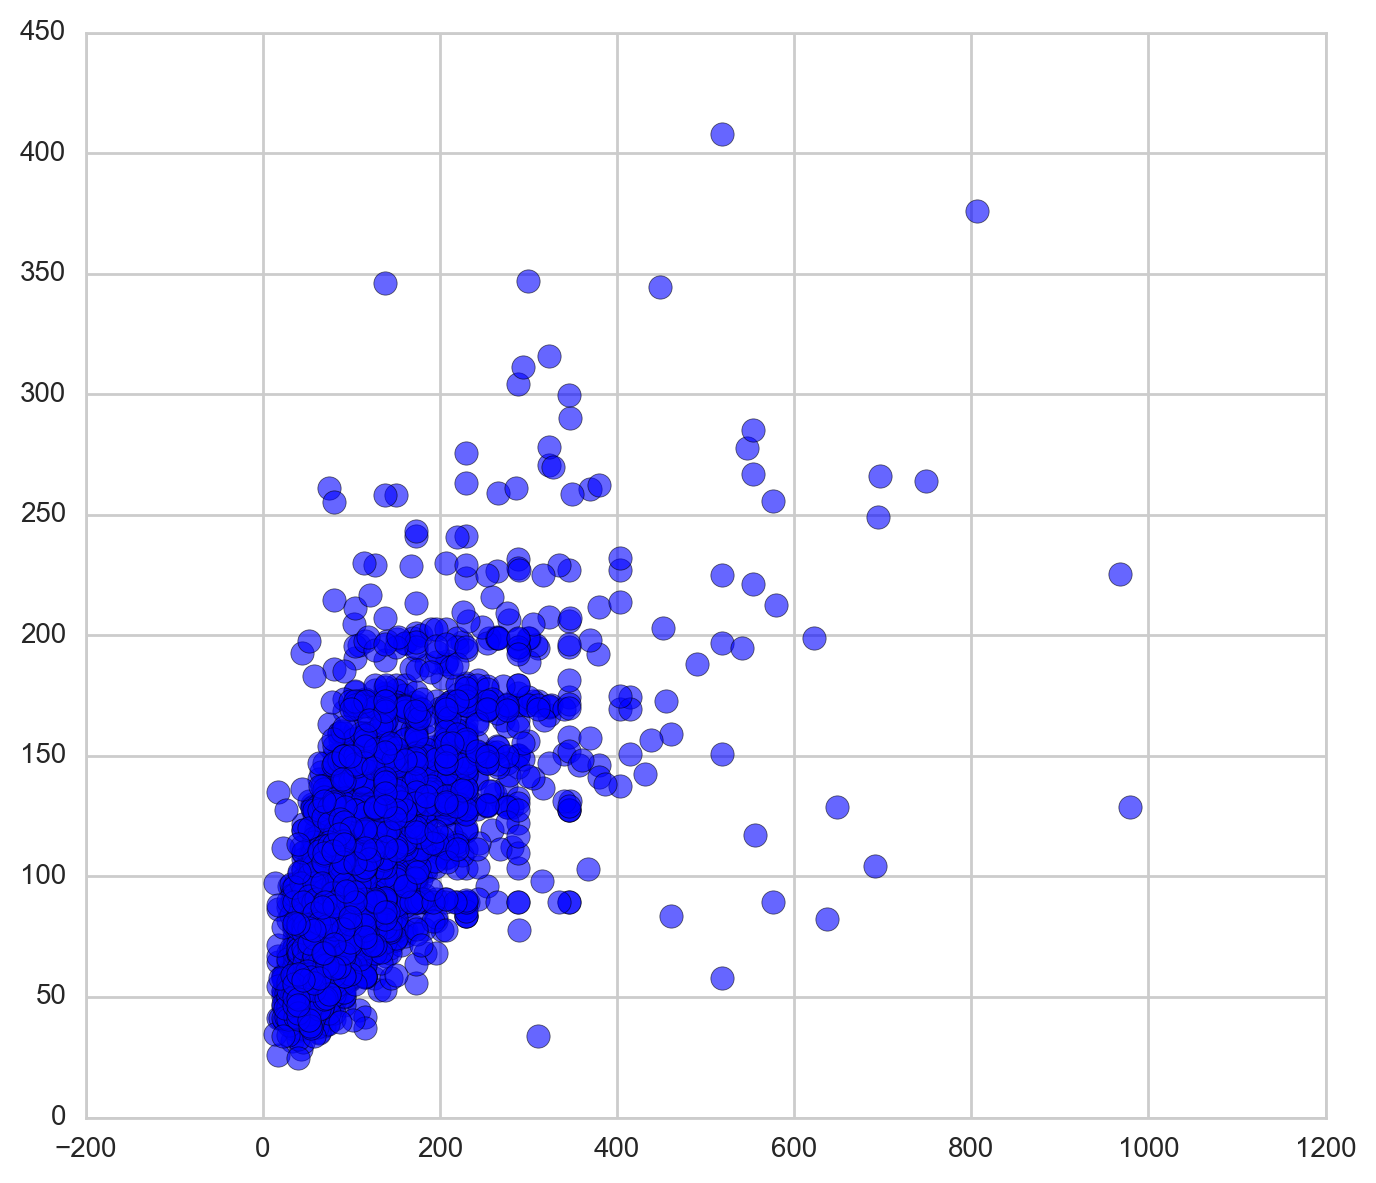

In [33]:
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(np.exp(y_test), np.exp(y_pred_enet), s=70, alpha=0.6)
plt.show()

In [34]:
# Based on above plot, I will remove all prices that are higher than 1000/night.

In [35]:
enet.fit(Xn_train, y_train)

enet_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':enet.coef_,
        'abscoef':np.abs(enet.coef_)
    })

enet_coef.sort_values('abscoef', ascending=False, inplace=True)
enet_coef[enet_coef.coef != 0].head(25)


,abscoef,coef,variable
14,0.169138,-0.169138,room_type[T.Private room]
23,0.167806,0.167806,rest_count
17,0.114341,0.114341,bedrooms
16,0.088837,0.088837,bathrooms
24,0.068589,-0.068589,reviews
15,0.068389,-0.068389,room_type[T.Shared room]
22,0.056132,-0.056132,overall_satisfaction
10,0.054481,-0.054481,neighborhood[Municipio 5]
4,0.028033,0.028033,neighborhood[Municipio 13]
11,0.015947,-0.015947,neighborhood[Municipio 7]


In [36]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

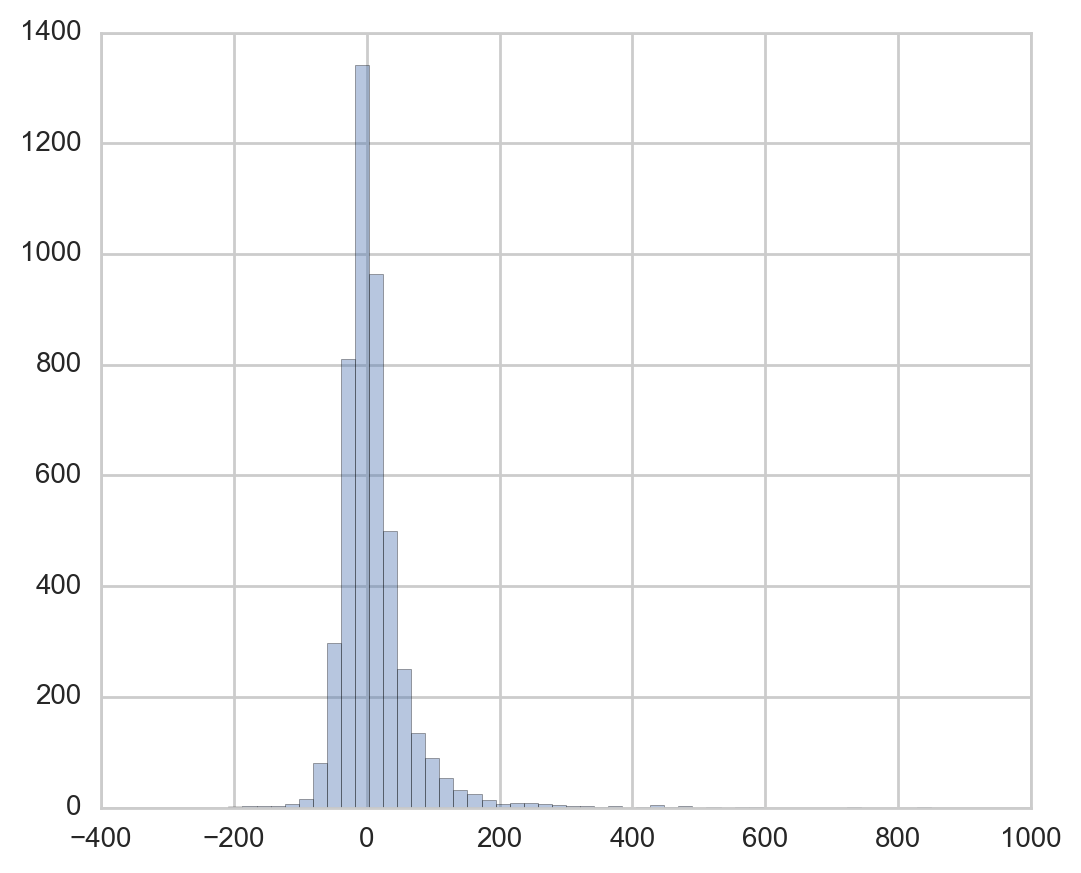

In [37]:
# plt.plot(residuals, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()
sns.distplot(residuals, bins=50, kde=False)

In [38]:
enet_coef = enet_coef.reset_index(drop=True)


In [39]:
linmod.fit(Xn_train, y_train)

linmod_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':linmod.coef_,
        'abscoef':np.abs(linmod.coef_)
    })

linmod_coef.sort_values('abscoef', ascending=False, inplace=True)
linmod_coef[linmod_coef.coef != 0].head(25)
linmod_coef = linmod_coef.reset_index(drop=True)

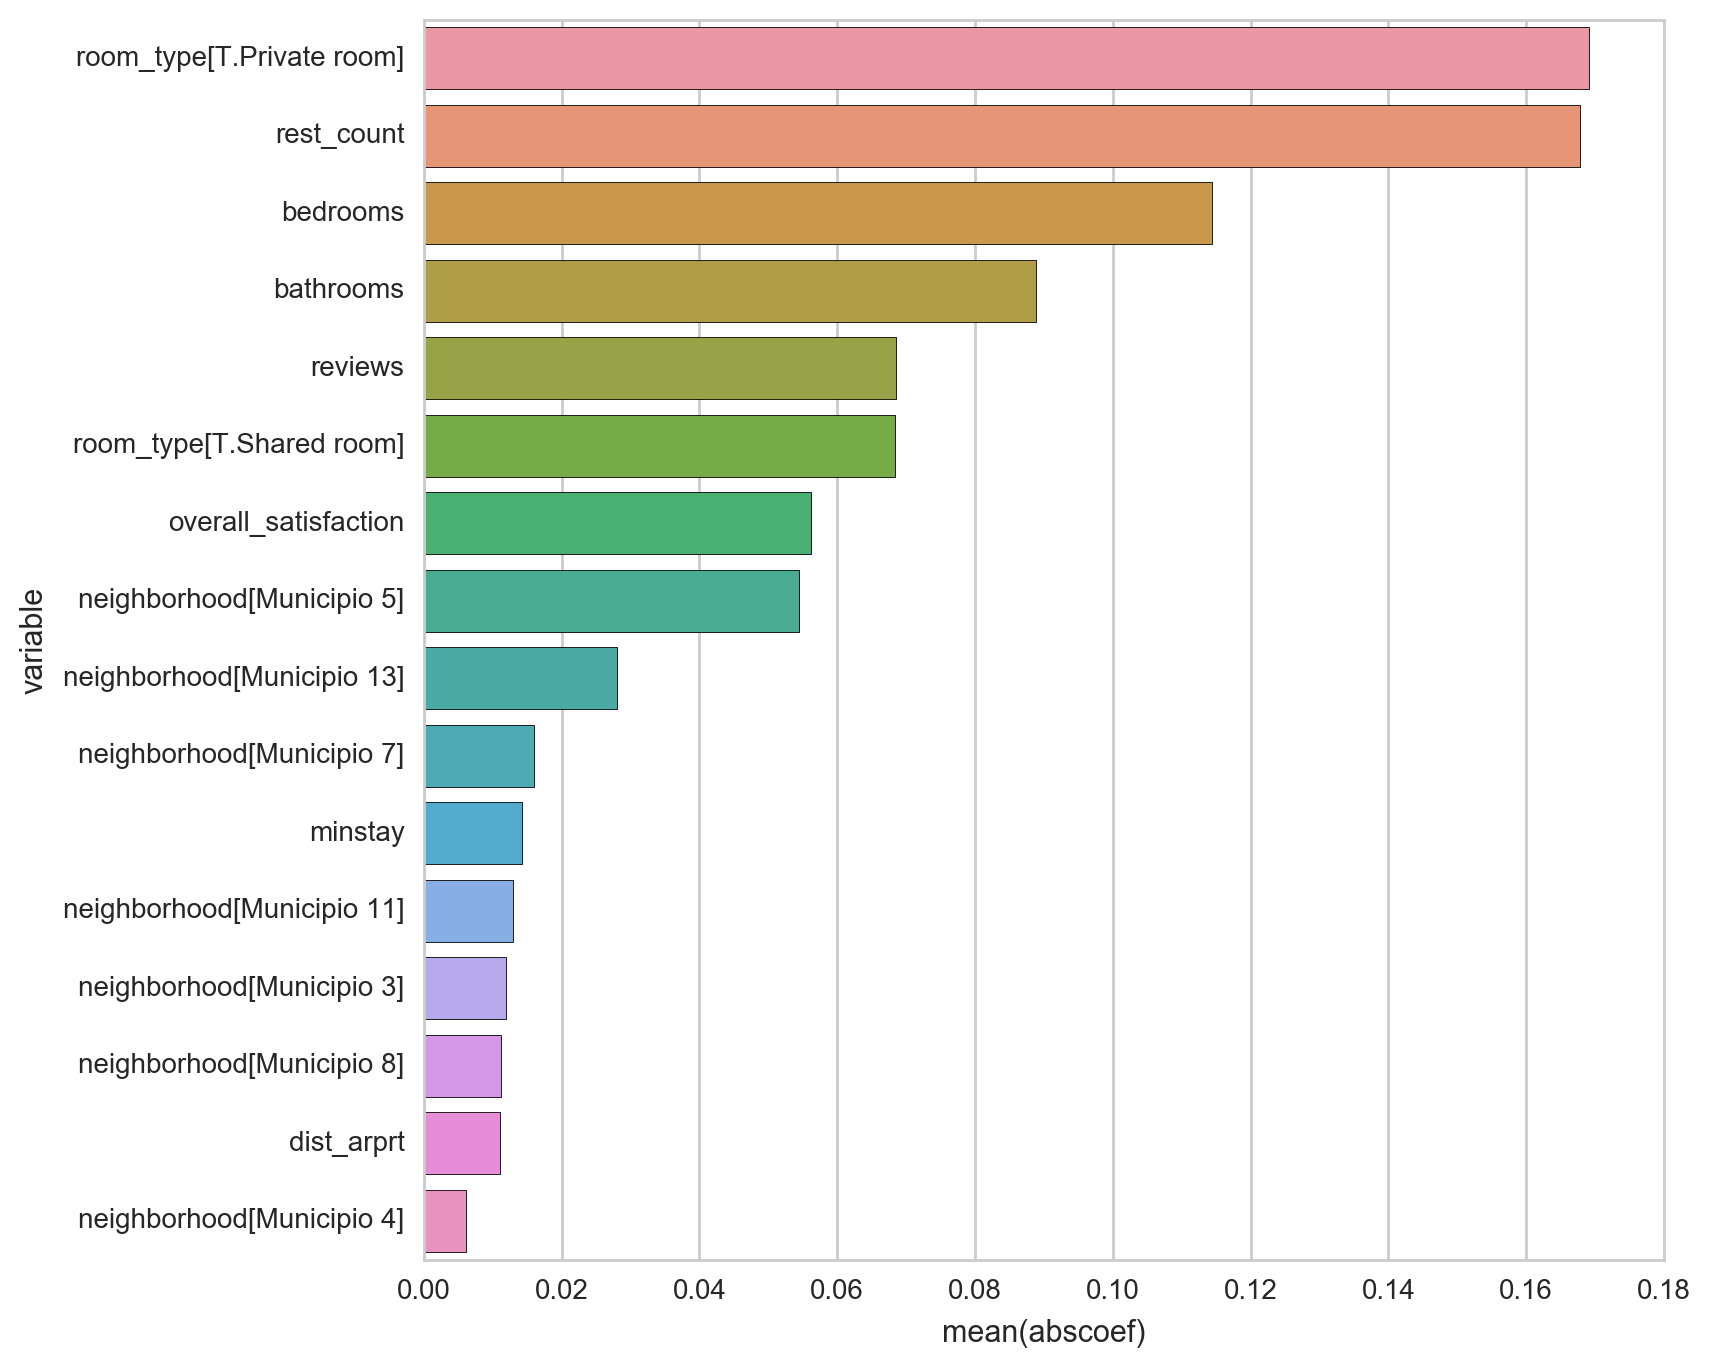

In [40]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef.loc[0:15,:].variable, x = enet_coef.loc[0:15,:].abscoef, data=enet_coef.loc[0:15,:],
            ax=ax
           )




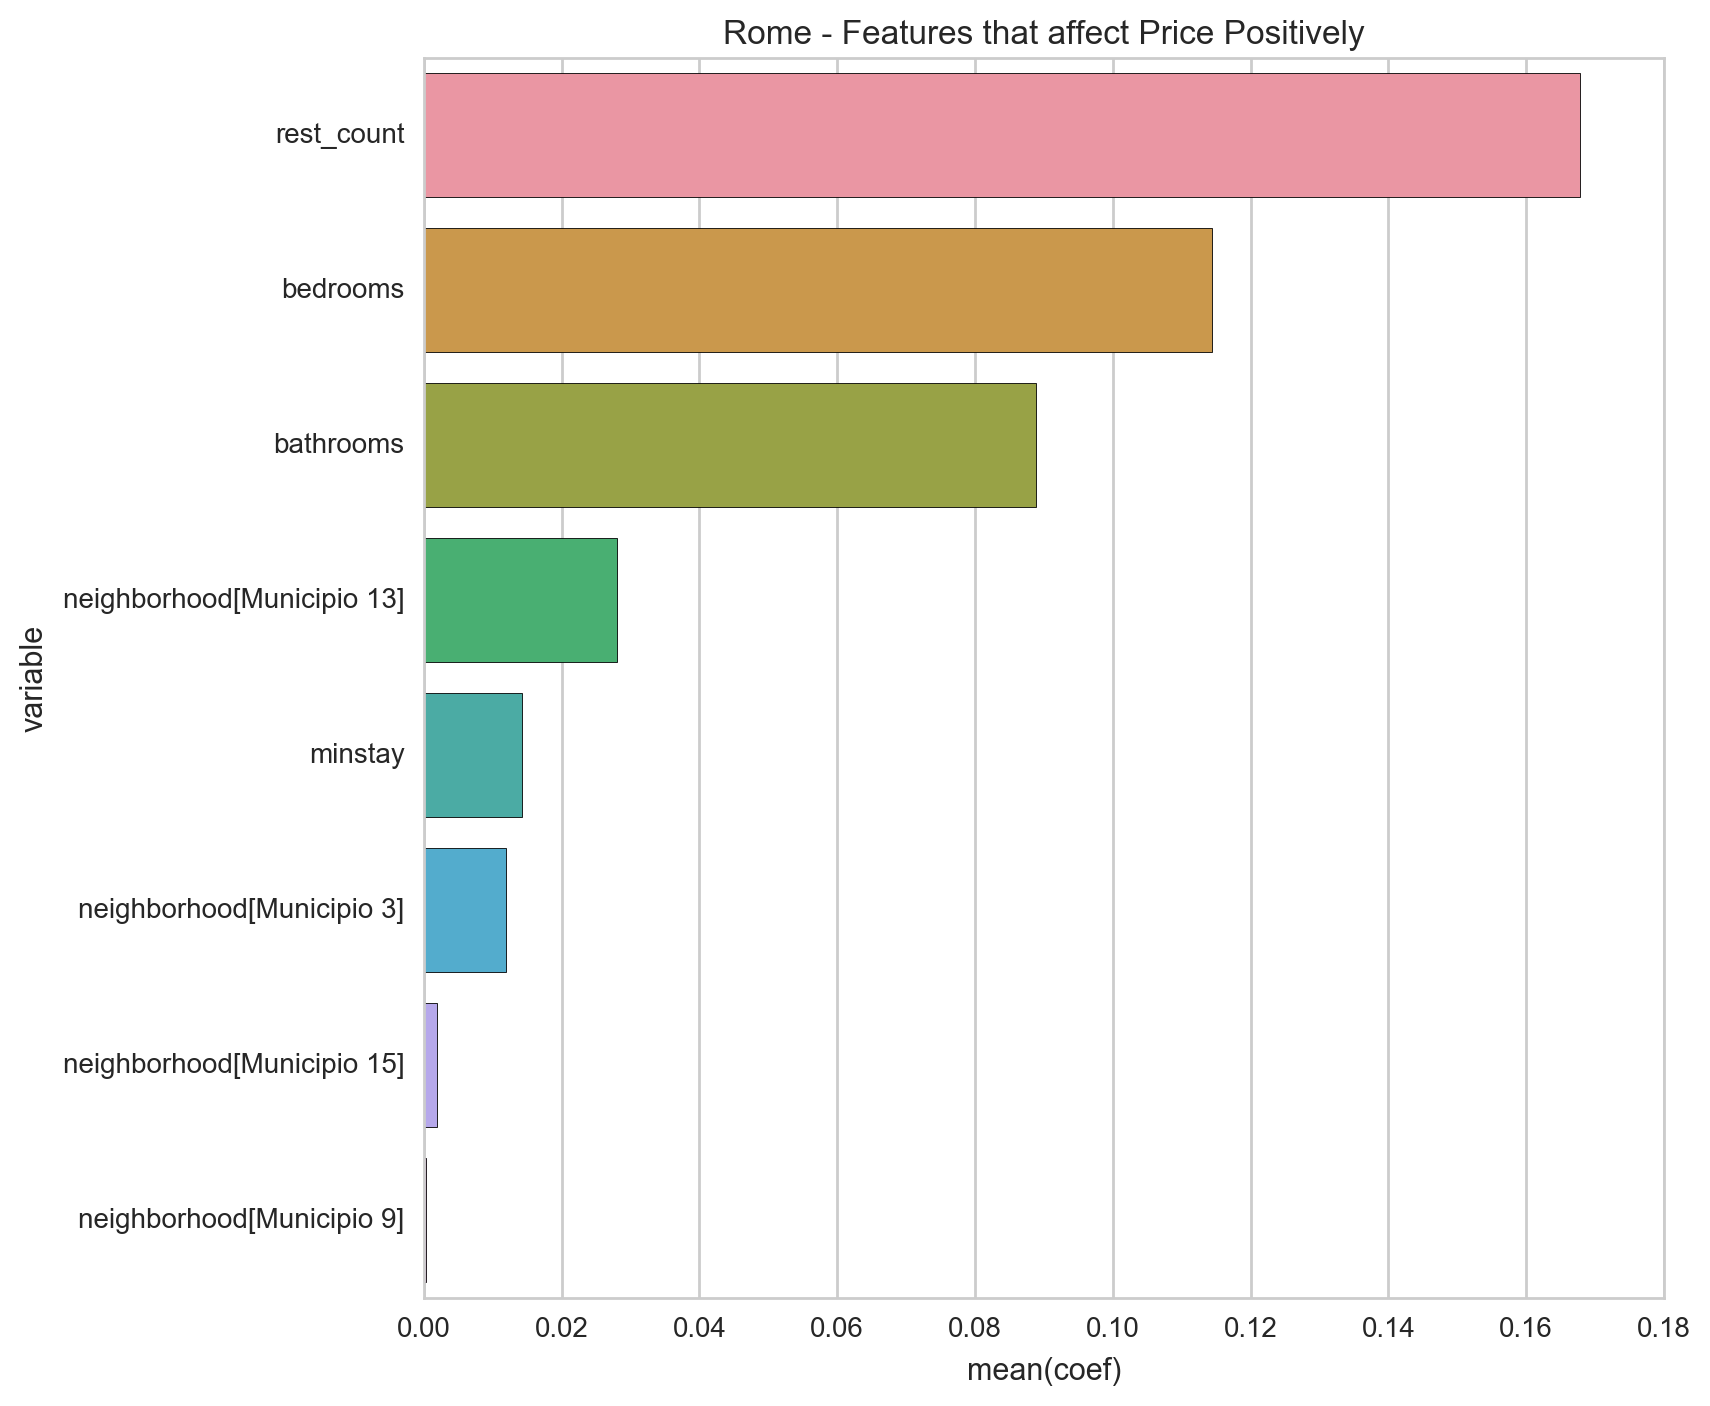

In [43]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef > 0].variable, x = enet_coef[enet_coef.coef > 0].coef, data=enet_coef,
            ax=ax
           )

ax.set_title("Rome - Features that affect Price Positively")
plt.show()

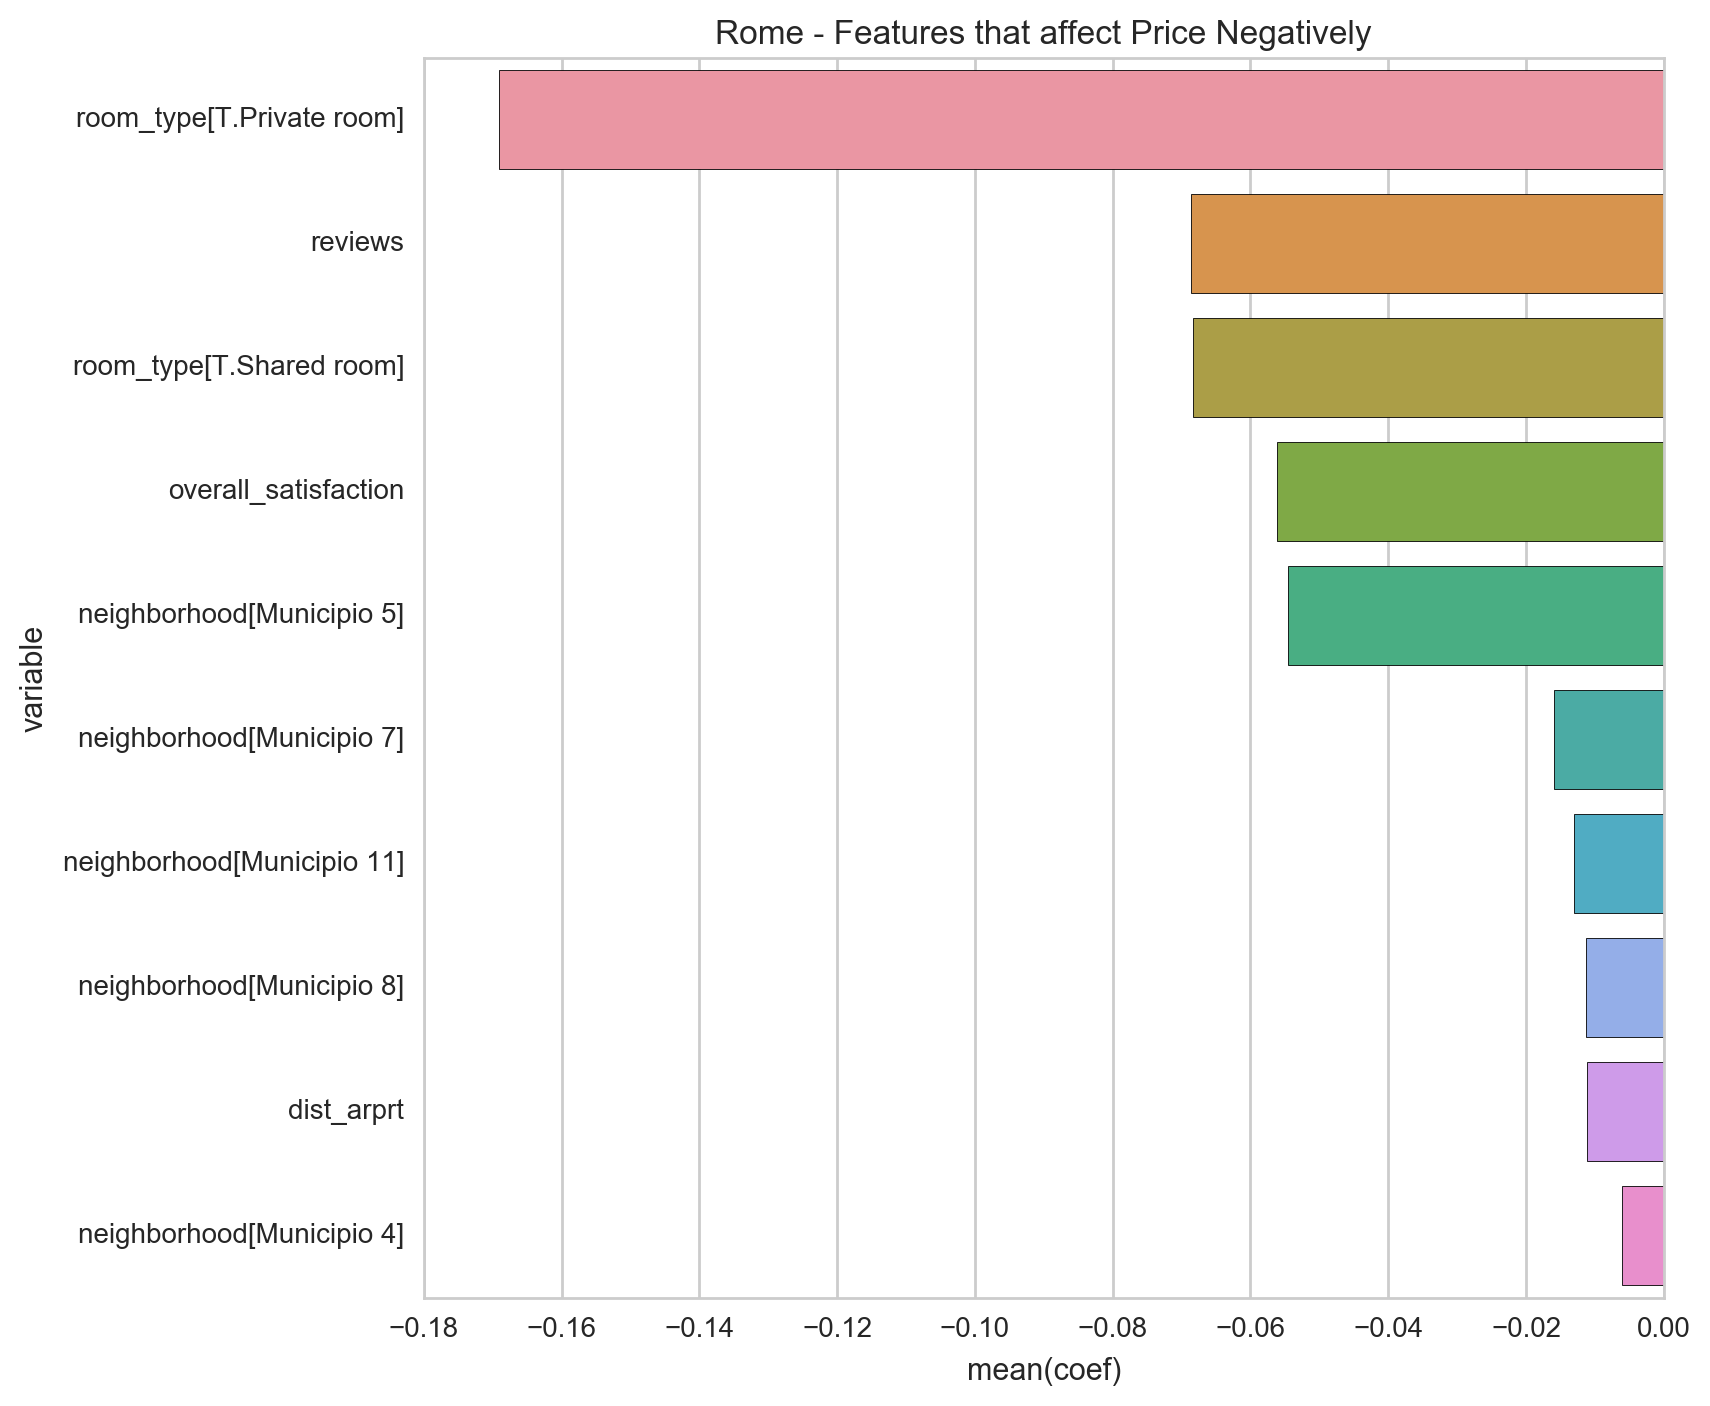

In [44]:
fig, ax = plt.subplots(figsize=(8,8))

sns.barplot(y = enet_coef[enet_coef.coef < 0].variable, x = enet_coef[enet_coef.coef < 0].coef, data=enet_coef,
            ax=ax
           )

ax.set_title("Rome - Features that affect Price Negatively")
plt.show()